<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/randomized_priors.ipynb" target="_parent"><img alt="Open in Colab" src="https://colab.research.google.com/assets/colab-badge.svg" ></a>

# Deep Ensembles with Randomized Prior Functions 

This notebook illustrates a way to improve predictive uncertainty using deep ensembles. It is based on this paper:

I. Osband, J. Aslanides, and A. Cassirer, “Randomized prior functions for deep reinforcement learning,” in NIPS, Jun. 2018 [Online]. Available: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf. 

The original  Tensorflow demo is from  https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

This JAX translation is by Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [ ]:
!pip -q install flax

     |████████████████████████████████| 184 kB 11.7 MB/s 
     |████████████████████████████████| 136 kB 46.6 MB/s 
     |████████████████████████████████| 72 kB 485 kB/s 


In [ ]:
%matplotlib inline

from functools import partial

import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
from jax import jit
from jax.nn.initializers import glorot_normal
import flax
import flax.linen as nn
from flax.training import train_state

# 1. Dataset

We will use a 1d synthetic regression dataset from this paper

C. Blundell, J. Cornebise, K. Kavukcuoglu, and D. Wierstra, “Weight Uncertainty in Neural Networks,” in ICML, May 2015 [Online]. Available: http://arxiv.org/abs/1505.05424


$$
\begin{align}
y &= x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, 0.02) \\
x &\sim \mathcal{U}(0.0, 0.5)
\end{align}
$$



In [ ]:
# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(key, x):
    epsilons = jax.random.normal(key, shape=(3,)) * 0.02
    return (
        x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
    )


# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

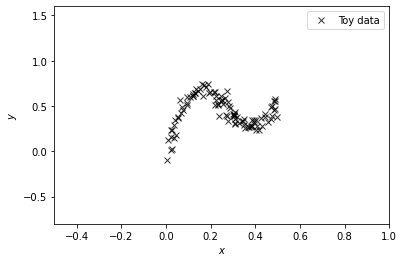

In [ ]:
# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

#2. Randomized Prior Functions

The core idea is to represent each ensemble member $g_i$ by
$$g_i(x; \theta_i) = t_i(x; \theta_i) + \beta p_i(x)$$,
where $t_i$ is a trainable network, and $p_i$ is a fixed, but random, prior network.

In [ ]:
# Prior and trainable networks have the same architecture
class GenericNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        dense = partial(nn.Dense, kernel_init=glorot_normal())
        return nn.Sequential([dense(16), nn.elu, dense(16), nn.elu, dense(1)])(x)


# Model that combines prior and trainable nets
class Model(nn.Module):
    prior: GenericNet = GenericNet()
    trainable: GenericNet = GenericNet()
    beta: float = 3

    @nn.compact
    def __call__(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2

In [ ]:
def create_train_state(key, X, lr):
    key, _ = jax.random.split(key)
    model = Model()
    params = model.init(key, X)["params"]
    p_params, t_params = params["prior"], params["trainable"]
    opt = optax.adam(learning_rate=lr)
    return p_params, train_state.TrainState.create(apply_fn=model.apply, params=t_params, tx=opt)


@jax.jit
def train_epoch(beta, prior, train_state, X, Y):
    def loss_fn(params):
        model = Model(beta=beta)
        Yhat = model.apply({"params": {"prior": prior, "trainable": params}}, X)
        loss = jnp.mean((Yhat - Y) ** 2)
        return loss

    Yhats, grads = jax.value_and_grad(loss_fn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state


def train(key, beta, lr, epochs, X, Y):
    p_params, train_state = create_train_state(key, X, lr)
    for epoch in range(1, epochs + 1):
        train_state = train_epoch(beta, p_params, train_state, X, Y)
    return {"prior": p_params, "trainable": train_state.params}


# Prediction function to be resued in Part 3
@jax.jit
def get_predictions(beta, params, X):
    p_param, t_param = params["prior"], params["trainable"]
    generic = GenericNet()
    model = Model(beta=beta)
    Y_prior = generic.apply({"params": p_param}, X)
    Y_trainable = generic.apply({"params": t_param}, X)
    Y_model = model.apply({"params": params}, X)
    return Y_prior, Y_trainable, Y_model

In [ ]:
beta = 3
epochs = 2000
learning_rate = 0.03

# Train the model and get predictions for x_grid
params = train(jax.random.PRNGKey(0), beta, learning_rate, epochs, X, Y)
Y_prior, Y_trainable, Y_model = get_predictions(beta, params, x_grid)

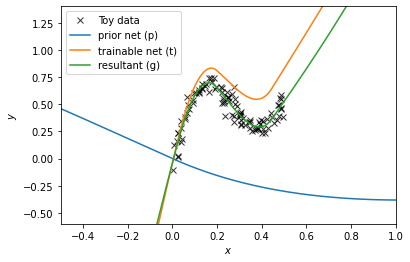

In [ ]:
# Plot the results
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
plt.plot(x_grid, 3 * Y_prior, label="prior net (p)")
plt.plot(x_grid, Y_trainable, label="trainable net (t)")
plt.plot(x_grid, Y_model, label="resultant (g)")
# plt.title('Predictions of the prior network: random function')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.6, 1.4)
plt.legend()

plt.savefig("randomized_priors_single_model.pdf")
plt.savefig("randomized_priors_single_model.png")

plt.show()

# 3. Bootstrapped Ensembles

To implement bootstrapping using JAX, we generate a random map from seed values to dataset index values: $\{\text{seed}, \text{seed}+1 \dots, \text{seed}+99\} \to \{ 0, 1, \dots, 99 \}$ by utilizing ``` jax.random.randint ```  using a randomly-generated seed. We assume the random key space is large enough that we need not be concerned with generating overlapping seed ranges.

In [ ]:
# Generate bootstrap of given size
def generate_bootstrap(key, size):
    seed, _ = jax.random.split(key)
    return [jax.random.randint(seed + i, (), 0, size) for i in range(size)]


# An ensemble model with randomized prior nets
def build_ensemble(n_estimators, beta, lr, epochs, X, Y, bootstrap):
    train_keys = jax.random.split(jax.random.PRNGKey(0), n_estimators)
    # Stack the (bootstrapped) training sets for the ensemble models
    if bootstrap:
        bootstraps = jnp.stack(
            jnp.array([generate_bootstrap(jax.random.PRNGKey(42 * i), X.shape[0]) for i in range(1, n_estimators + 1)])
        )
        X_b = jnp.expand_dims(jax.vmap(jnp.take, in_axes=(None, 0))(X, bootstraps), 2)
        Y_b = jnp.expand_dims(jax.vmap(jnp.take, in_axes=(None, 0))(Y, bootstraps), 2)
    else:
        X_b = jnp.tile(X, (n_estimators, 1, 1))
        Y_b = jnp.tile(Y, (n_estimators, 1, 1))
    # Train each ensemble model on its corresponding training set
    ensemble_train = jax.vmap(train, in_axes=(0, None, None, None, 0, 0), out_axes={"prior": 0, "trainable": 0})
    return ensemble_train(train_keys, beta, lr, epochs, X_b, Y_b)


# Array of predictions for each model in trained ensemble
def get_ensemble_predictions(n_estimators, beta, lr, epochs, X, Y, X_new, bootstrap=True):
    ensemble = build_ensemble(n_estimators, beta, lr, epochs, X, Y, bootstrap)
    result = jax.vmap(get_predictions, in_axes=(None, 0, None))(beta, ensemble, X_new)
    return result

In [ ]:
# Compute prediction values for each net in ensemble
n_estimators = 9
beta = 3
learning_rate = 0.03
epochs = 3000
p_grid, t_grid, y_grid = get_ensemble_predictions(n_estimators, beta, learning_rate, epochs, X, Y, x_grid)

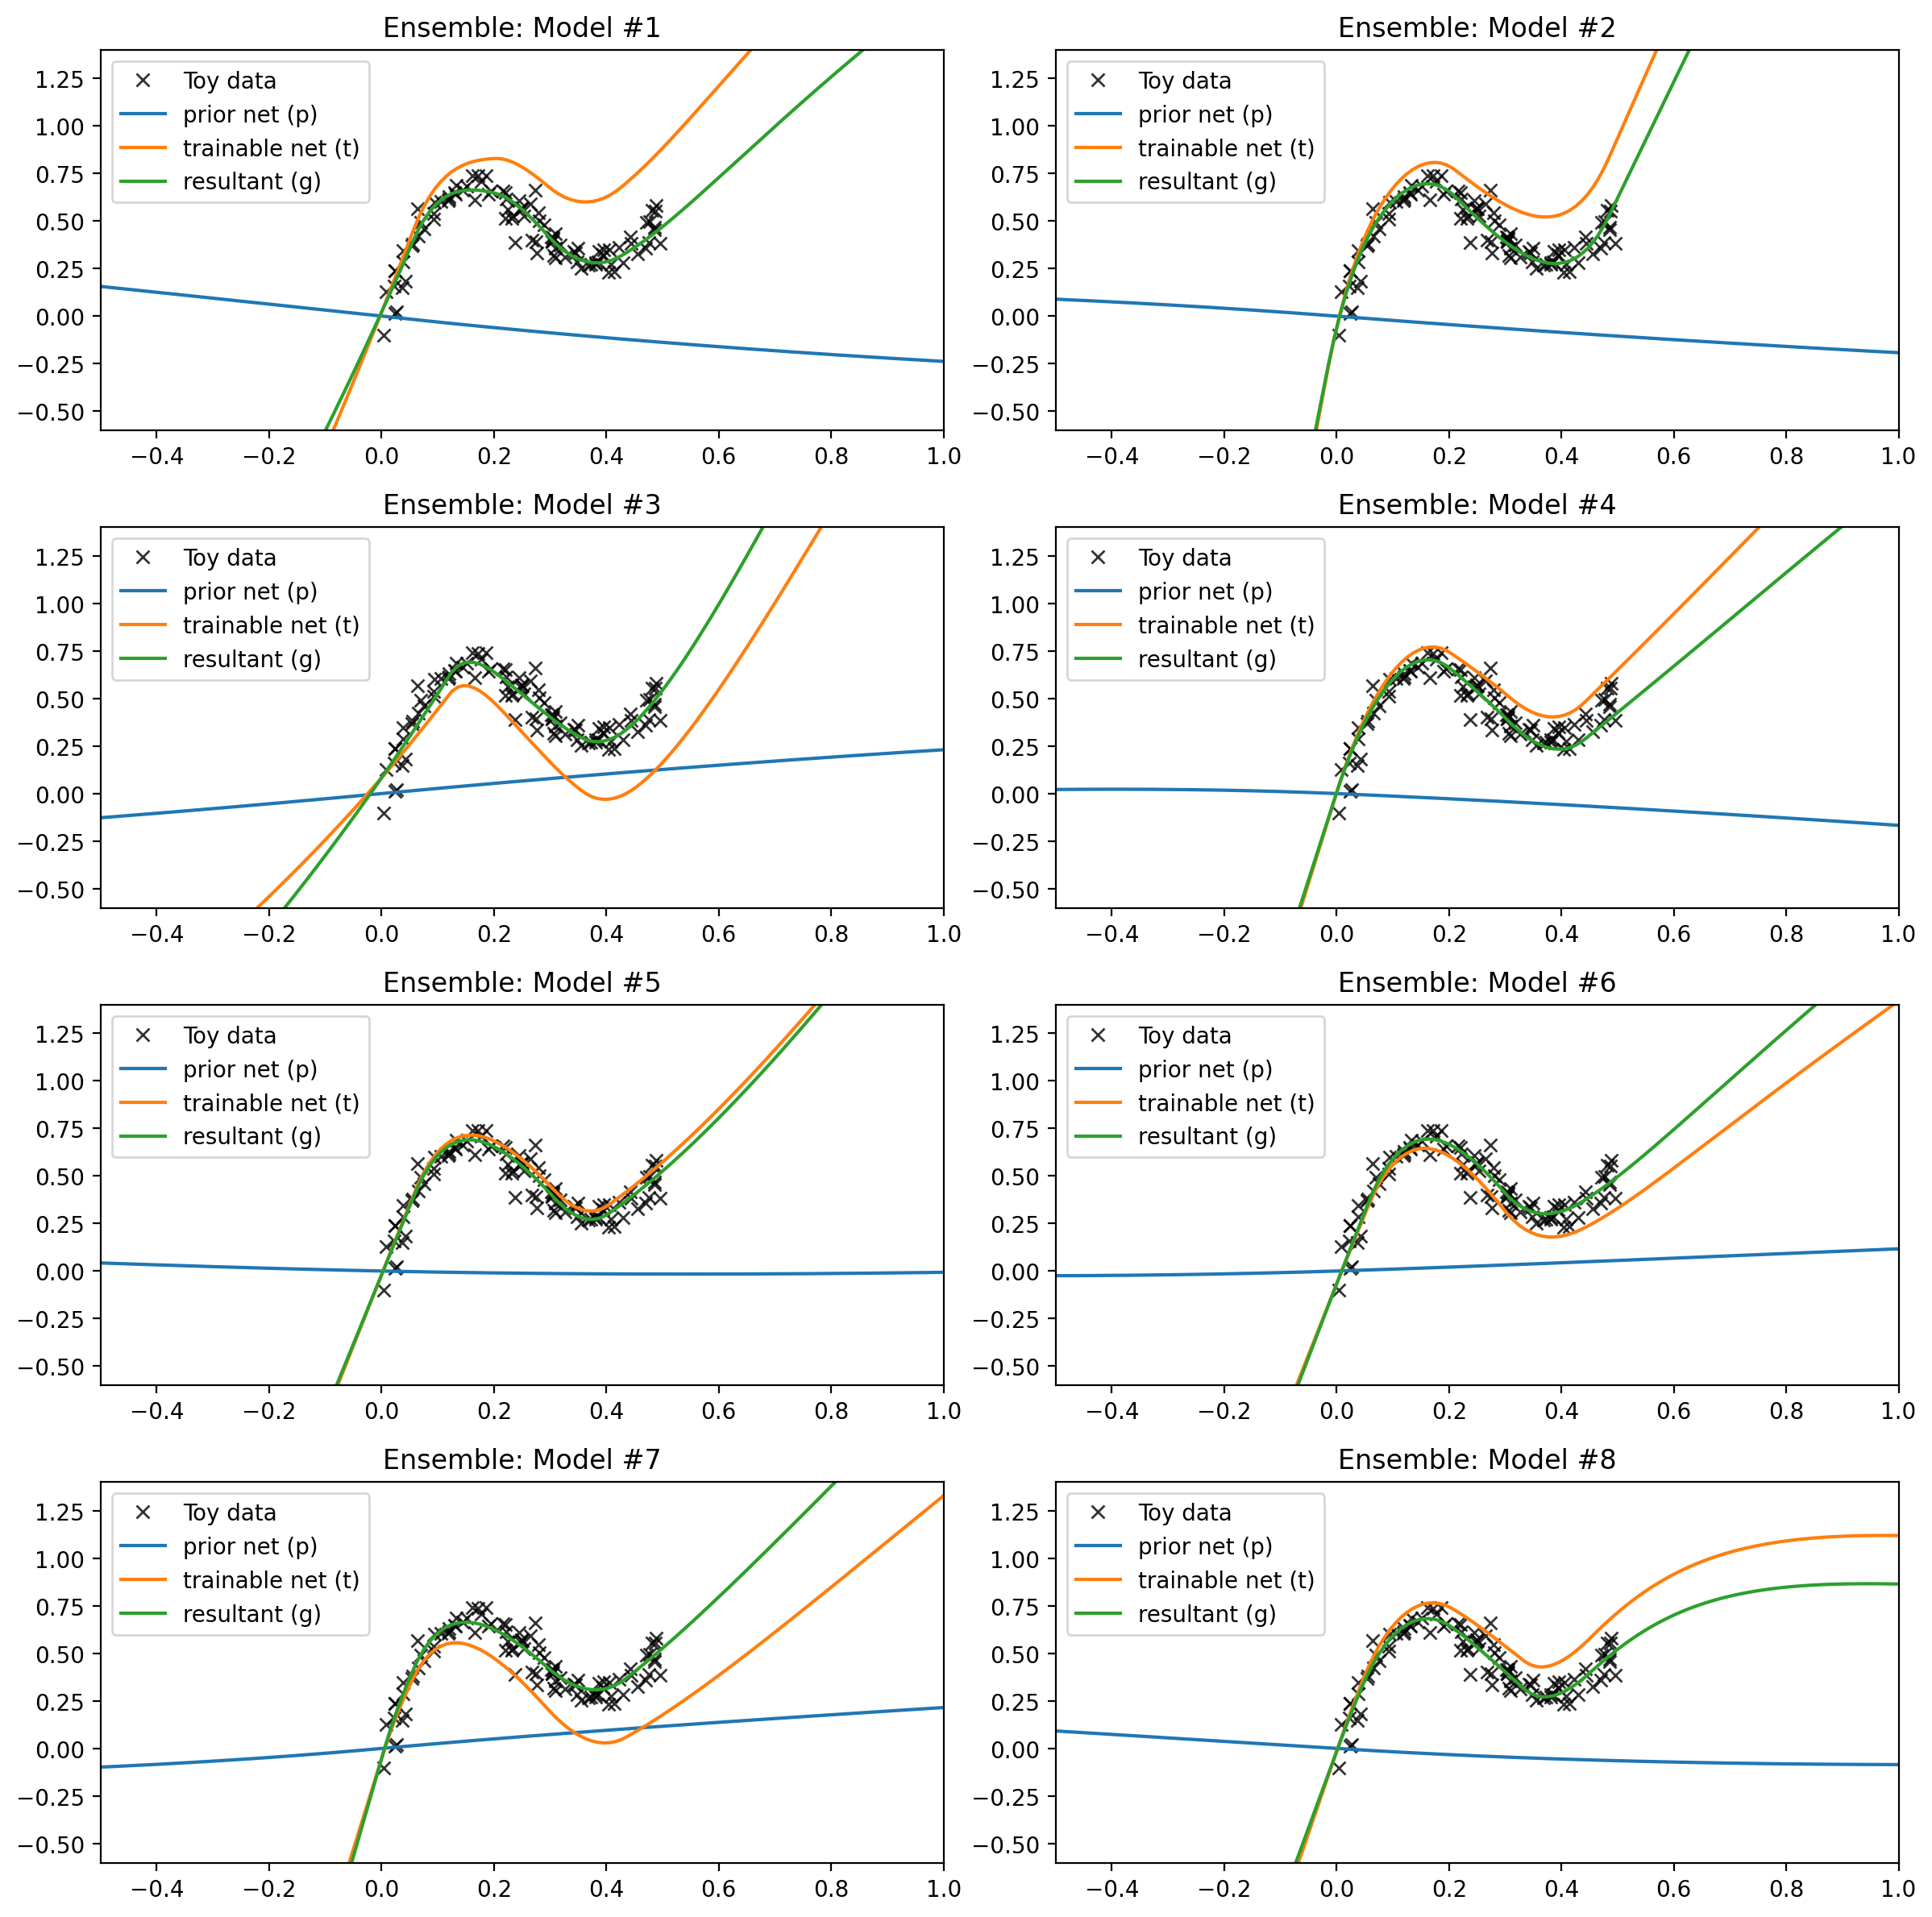

In [ ]:
# Plot the results
plt.figure(figsize=[12, 12], dpi=200)
for i in range(8):
    plt.subplot(4, 2, i + 1)
    plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
    plt.plot(x_grid, p_grid[i, :, 0], label="prior net (p)")
    plt.plot(x_grid, t_grid[i, :, 0], label="trainable net (t)")
    plt.plot(x_grid, y_grid[i, :, 0], label="resultant (g)")
    plt.title("Ensemble: Model #{}".format(i + 1))
    # plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.6, 1.4)
    # plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    plt.legend()

plt.tight_layout()

plt.savefig("randomized_priors_multi_model.pdf")
plt.savefig("randomized_priors_multi_model.png")
plt.show();

# 4. Effects of Changing Beta

Let us go beyond the original Kaggle notebook and inspect that relationship between the weight of the prior, $\beta$ and the variance among the predictions of the ensembled models.

Intuitively, since the random priors are not trained, the variance should increase with $\beta$. Let us verify this visually.

In [ ]:
# Choose a diverse selection of beta values
betas = jnp.array([0.001, 5, 50, 100])

n_estimates, lr, epochs = 9, 0.03, 3000

# Get ensemble predictions for the corresponding beta values
pred_beta_batches = jax.vmap(
    get_ensemble_predictions,
    in_axes=(
        None,
        0,
        None,
        None,
        None,
        None,
        None,
    ),
)

preds = pred_beta_batches(n_estimates, betas, lr, epochs, X, Y, x_grid)
means = jax.vmap(lambda x: x.mean(axis=0)[:, 0])(preds[2])
stds = jax.vmap(lambda x: x.std(axis=0)[:, 0])(preds[2])

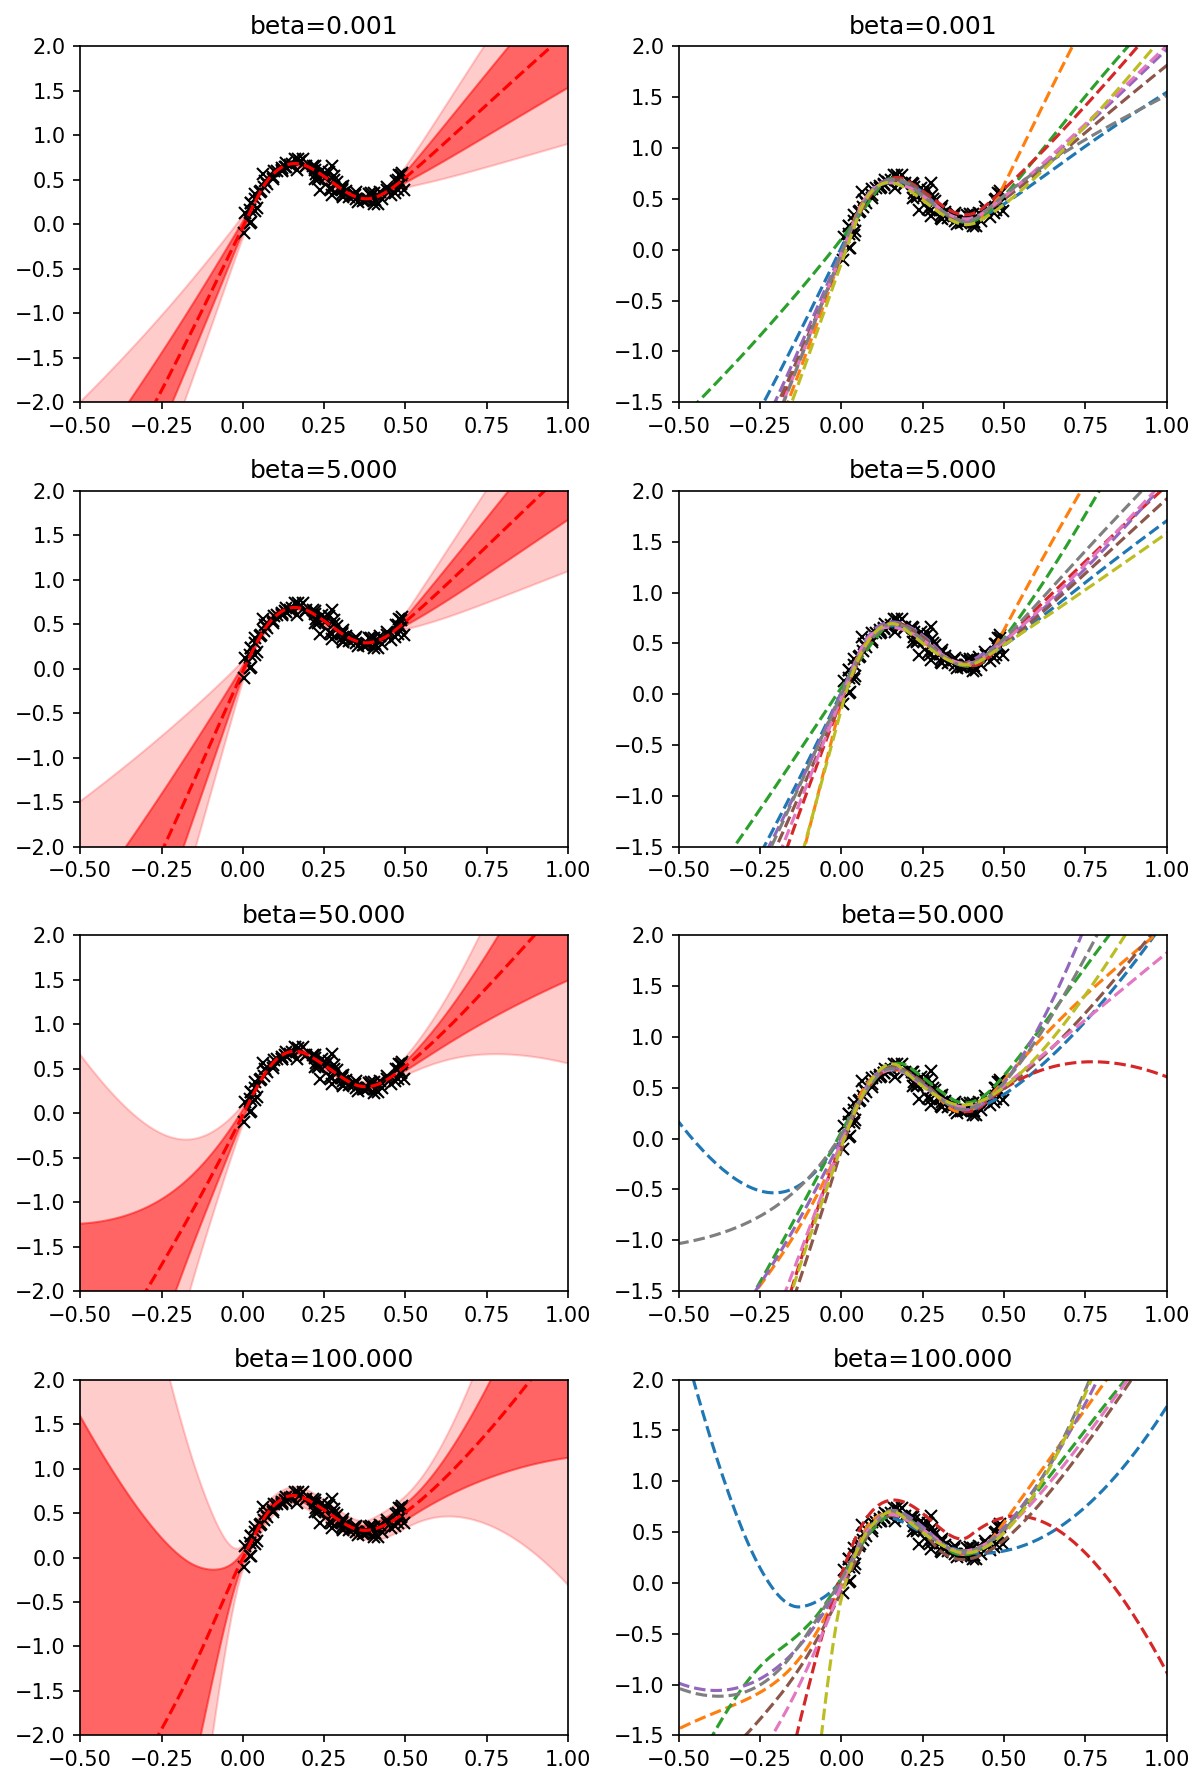

In [ ]:
# Plot mean and std for each beta
fig = plt.figure(figsize=[8, len(betas) * 3], dpi=150)
for i, beta in enumerate(betas):
    # Plot predictive mean and std (left graph)
    plt.subplot(len(betas), 2, 2 * i + 1)
    plt.plot(X, Y, "kx", label="Toy data")
    # plt.title(f'Mean and Deviation for beta={beta}', fontsize=12)
    plt.title(f"beta={beta:.3f}")
    plt.xlim(-0.5, 1.0)
    plt.ylim(-2, 2)
    # plt.legend()
    plt.plot(x_grid, means[i], "r--", linewidth=1.5)
    plt.fill_between(x_grid.reshape(1, -1)[0], means[i] - stds[i], means[i] + stds[i], alpha=0.5, color="red")
    plt.fill_between(x_grid.reshape(1, -1)[0], means[i] + 2 * stds[i], means[i] - 2 * stds[i], alpha=0.2, color="red")

    # Plot means of each net in ensemble (right graph)
    plt.subplot(len(betas), 2, 2 * i + 2)
    plt.plot(X, Y, "kx", label="Toy data")
    # plt.title(f'Samples for beta={beta}', fontsize=12)
    plt.title(f"beta={beta:.3f}")
    plt.xlim(-0.5, 1.0)
    plt.ylim(-1.5, 2)
    # plt.legend()
    for j in range(n_estimators):
        plt.plot(x_grid, preds[2][i][j, :, 0], linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.savefig("randomized_priors_changing_beta.pdf")
plt.savefig("randomized_priors_changing_beta.png")
plt.show()

# 5. Effects of Prior and Bootstrapping

Let us construct and compare the following four models:


1. Ensemble of nets **with** prior, **with** bootstrap (original model)
2. Ensemble of nets **with** prior, **without** bootstrap
3. Ensemble of nets **without** prior, **with** bootstrap
4. Ensemble of nets **without** prior, **without** bootstrap

Note that our previous constructions allow easy extensions into the three other model types. For nets without prior, we simply set ```beta=0``` (or, alternatively, use```GenericNet```) and for nets without bootstrap, we use the method ```get_ensemble_predictions(..., bootstrap=False)```.

In [ ]:
n, beta, lr, epochs = 9, 50, 0.03, 3000

# With prior, with bootstrap (original)
*_, y_grid_1 = get_ensemble_predictions(n, beta, lr, epochs, X, Y, x_grid)
means_1, stds_1 = y_grid_1.mean(axis=0)[:, 0], y_grid_1.std(axis=0)[:, 0]
# With prior, without bootstrap
*_, y_grid_2 = get_ensemble_predictions(n, beta, lr, epochs, X, Y, x_grid, False)
means_2, stds_2 = y_grid_2.mean(axis=0)[:, 0], y_grid_2.std(axis=0)[:, 0]
# Without prior, with bootstrap
*_, y_grid_3 = get_ensemble_predictions(n, 0, lr, epochs, X, Y, x_grid)
means_3, stds_3 = y_grid_3.mean(axis=0)[:, 0], y_grid_3.std(axis=0)[:, 0]
# Without prior, without bootstrap
*_, y_grid_4 = get_ensemble_predictions(n, 0, lr, epochs, X, Y, x_grid, False)
means_4, stds_4 = y_grid_4.mean(axis=0)[:, 0], y_grid_4.std(axis=0)[:, 0]

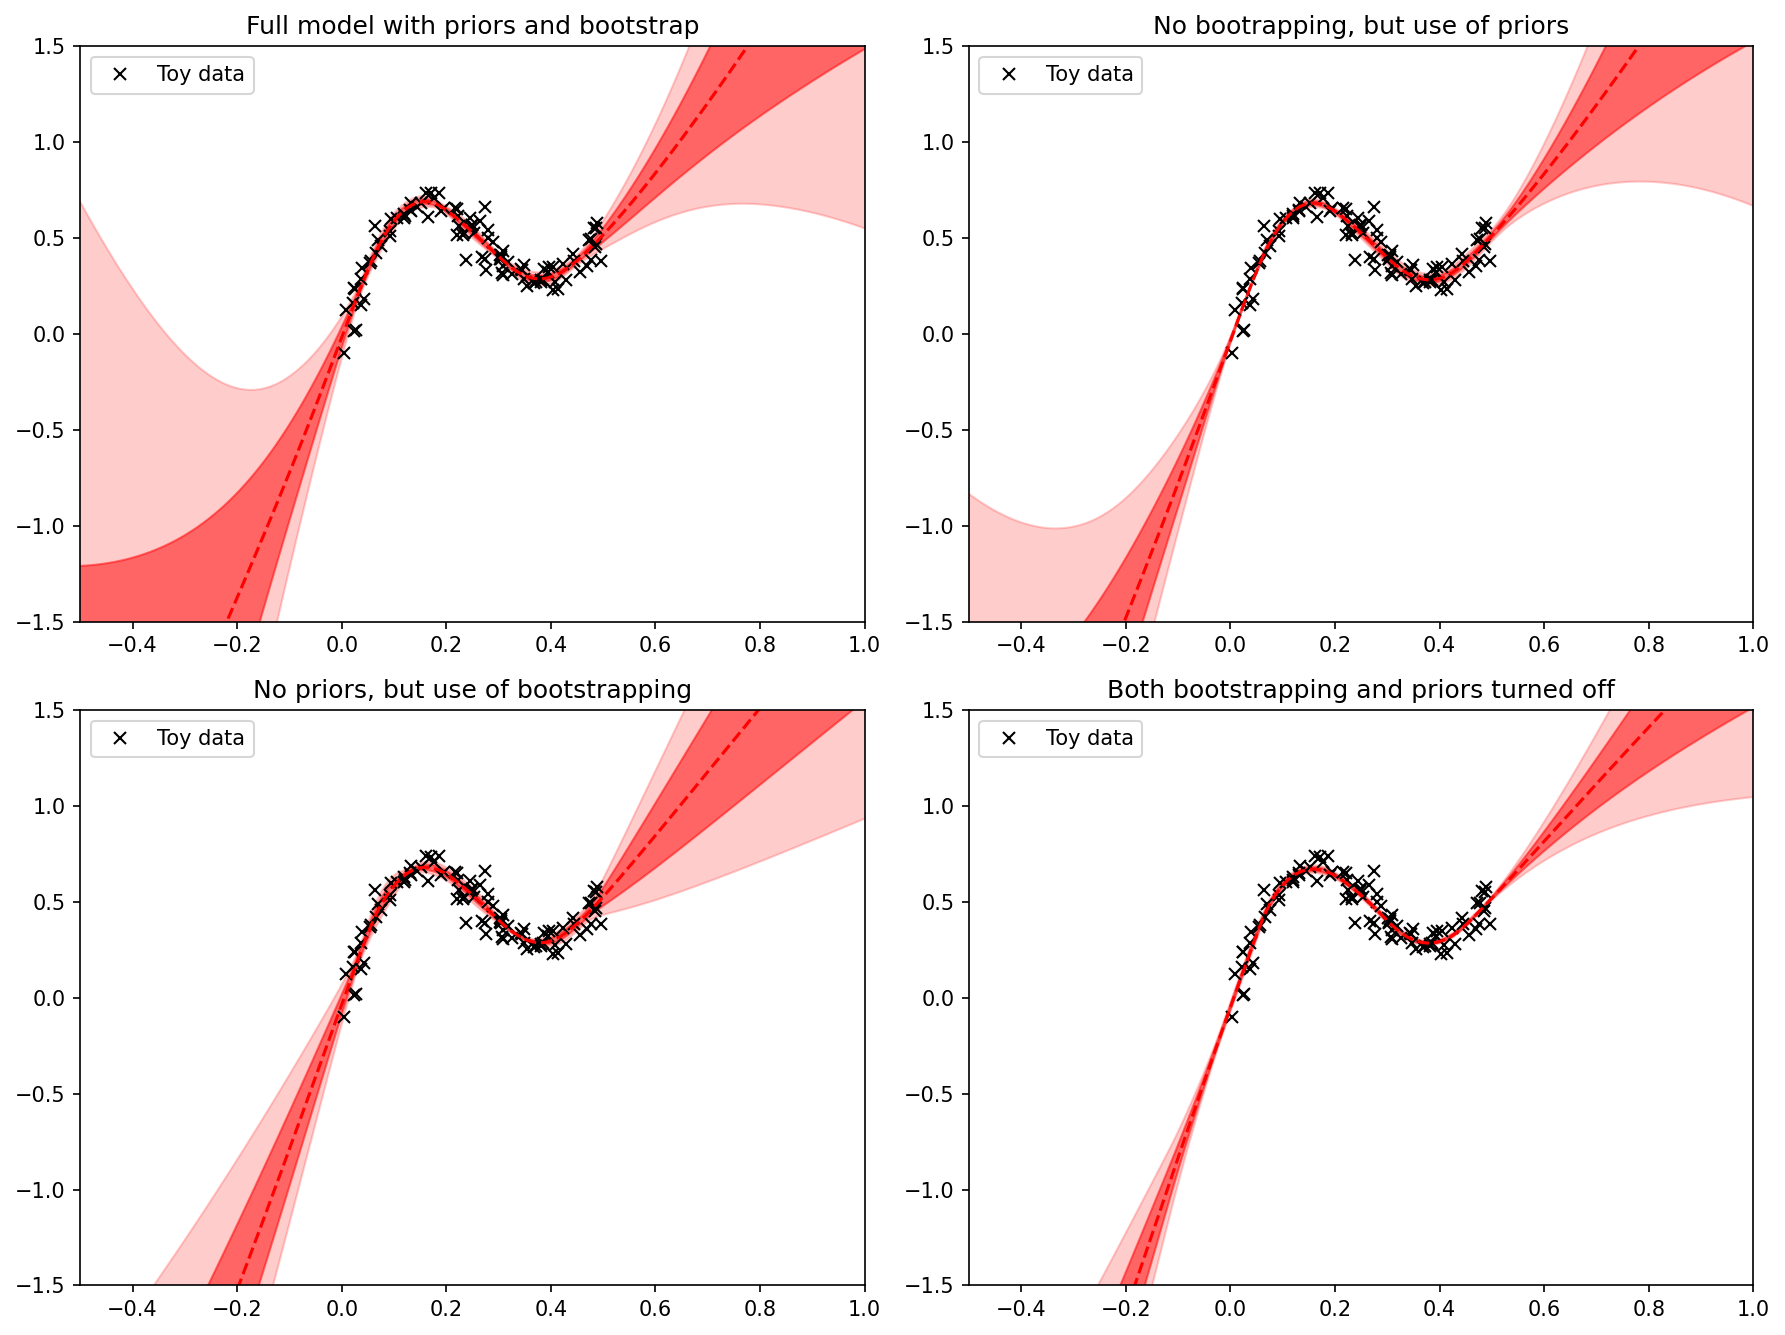

In [ ]:
# Plot the four types of models
fig = plt.figure(figsize=[12, 9], dpi=150)
# fig.suptitle('Bootstrapping and priors: impact of model components on result',
#             verticalalignment='center')

# With prior, with bootstrap
plt.subplot(2, 2, 1)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Full model with priors and bootstrap", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_1, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_1 - stds_1, means_1 + stds_1, alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], means_1 + 2 * stds_1, means_1 - 2 * stds_1, alpha=0.2, color="red")

# With prior, without bootstrap
plt.subplot(2, 2, 2)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No bootrapping, but use of priors", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_2, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_2 - stds_2, means_2 + stds_2, alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], means_2 + 2 * stds_2, means_2 - 2 * stds_2, alpha=0.2, color="red")

# Without prior, with bootstrap
plt.subplot(2, 2, 3)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No priors, but use of bootstrapping", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_3, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_3 - stds_3, means_3 + stds_3, alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], means_3 + 2 * stds_3, means_3 - 2 * stds_3, alpha=0.2, color="red")

# Without prior, without bootstrap
plt.subplot(2, 2, 4)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Both bootstrapping and priors turned off", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_4, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_4 - stds_4, means_4 + stds_4, alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], means_4 + 2 * stds_4, means_4 - 2 * stds_4, alpha=0.2, color="red")

plt.tight_layout()
plt.savefig("randomized_priors_components.pdf")
plt.savefig("randomized_priors_components.png")
plt.show();